# Unsupervised Learning for Single-Cell RNA-Sequencing Data

## Tutorial Overview

This tutorial demonstrates unsupervised learning techniques applied to single-cell RNA-sequencing (scRNA-seq) data. We will explore:

1. **Data Loading and Visualization**: Understanding single-cell RNA-seq data structure
2. **Dimensionality Reduction**: PCA, UMAP, and t-SNE for visualization
3. **Clustering**: K-means clustering to identify cell types
4. **Advanced Methods**: Variational Autoencoders (VAE) and Louvain graph-based clustering

---

## Background: Single-Cell RNA-Sequencing

Single-cell RNA-sequencing (scRNA-seq) is a powerful technology that measures gene expression at the individual cell level. Unlike bulk RNA-seq which measures average expression across thousands of cells, scRNA-seq allows us to:

- **Identify cell types** based on gene expression patterns
- **Discover cellular heterogeneity** within tissues
- **Track developmental trajectories** and cell state transitions
- **Understand disease mechanisms** at cellular resolution

### Key Challenges:
- **High dimensionality**: Thousands of genes (features) per cell
- **Sparsity**: Many genes have zero or very low expression
- **Noise**: Technical and biological variability
- **Large scale**: Modern datasets contain 10,000+ cells

### Data Structure:
- **Rows**: Individual cells
- **Columns**: Genes (features)
- **Values**: Gene expression counts (typically log-normalized)


## Data Download Instructions### Using the PBMC68k (Full Dataset) Dataset (Peripheral Blood Mononuclear Cells)This notebook uses the **PBMC68k (Full Dataset) dataset**, a well-known single-cell RNA-seq dataset of ~700 peripheral blood mononuclear cells (PBMCs) from a healthy donor. This dataset is the Python equivalent of the SeuratData `pbmc68k (full)` dataset.#### Automatic DownloadThe dataset will be **automatically downloaded** when you run the data loading cell using `scanpy.datasets.pbmc68k (full)()`. No manual download is required!#### Dataset Information- **Source**: 10x Genomics- **Cells**: ~~700 peripheral blood mononuclear cells- **Cell Types**: Multiple immune cell types including:  - T cells (CD4+ and CD8+)  - B cells  - Monocytes  - NK cells  - Dendritic cells- **Reference**: This is a standard benchmark dataset used in many single-cell analysis tutorials- **Download Location**: The data is automatically cached by scanpy in your home directory (`~/.cache/scipy-data/`)#### Alternative: Using Your Own DataIf you want to use a different dataset, you can modify the data loading cell to:1. Load from a file (CSV, TSV, H5AD format)2. Use other scanpy datasets (e.g., `scanpy.datasets.pbmc68k (full)()`)3. Load from public repositories (GEO, ArrayExpress)**Note**: The notebook will automatically handle data loading and preprocessing, including log transformation and feature selection.

## 1. Data Loading and Initial Exploration



Let's start by loading the single-cell RNA-seq data and exploring its structure.


In [49]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

# Import scanpy for loading single-cell datasets
try:
    import scanpy as sc
    print("scanpy imported successfully!")
except ImportError:
    print("Warning: scanpy not installed. Install with: pip install scanpy")

# Set plotting style
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")


scanpy imported successfully!
Libraries imported successfully!


In [50]:
# Load single-cell RNA-seq data - Full PBMC68k dataset from 10x Genomics
# This will download ~68,000 cells (much larger than the reduced version)
import scanpy as sc
import os
import urllib.request
from pathlib import Path

print("Loading full PBMC68k dataset from 10x Genomics...")
print("(This will download the dataset automatically on first use)")

# URL for the full PBMC68k dataset
data_url = "https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc68k/pbmc68k_filtered_gene_bc_matrices.tar.gz"
data_dir = "../examples/data/pbmc68k"
h5_file = os.path.join(data_dir, "filtered_gene_bc_matrices_h5.h5")
matrix_dir = os.path.join(data_dir, "filtered_gene_bc_matrices", "hg19")

# Check if data already exists
if os.path.exists(h5_file):
    print(f"\nFound existing H5 file: {h5_file}")
    adata = sc.read_10x_h5(h5_file)
elif os.path.exists(matrix_dir):
    print(f"\nFound existing matrix directory: {matrix_dir}")
    adata = sc.read_10x_mtx(matrix_dir, var_names='gene_symbols', cache=True)
else:
    print("\nDownloading PBMC68k dataset from 10x Genomics...")
    print("(This may take a few minutes - the file is ~1.3 GB)")
    
    # Create data directory
    os.makedirs(data_dir, exist_ok=True)
    
    # Download the tar.gz file
    tar_file = os.path.join(data_dir, "pbmc68k_filtered_gene_bc_matrices.tar.gz")
    if not os.path.exists(tar_file):
        print(f"Downloading to {tar_file}...")
        urllib.request.urlretrieve(data_url, tar_file)
        print("Download complete!")
    
    # Extract the tar.gz file
    import tarfile
    print("Extracting archive...")
    with tarfile.open(tar_file, 'r:gz') as tar:
        tar.extractall(data_dir)
    print("Extraction complete!")
    
    # Try to read from H5 file first, then matrix directory
    if os.path.exists(h5_file):
        print(f"\nReading from H5 file: {h5_file}")
        adata = sc.read_10x_h5(h5_file)
    elif os.path.exists(matrix_dir):
        print(f"\nReading from matrix directory: {matrix_dir}")
        adata = sc.read_10x_mtx(matrix_dir, var_names='gene_symbols', cache=True)
    else:
        # Fallback: try to find the matrix directory
        import glob
        possible_dirs = glob.glob(os.path.join(data_dir, "**/filtered_gene_bc_matrices/*"), recursive=True)
        if possible_dirs:
            matrix_dir = os.path.dirname(possible_dirs[0])
            print(f"\nFound matrix directory: {matrix_dir}")
            adata = sc.read_10x_mtx(matrix_dir, var_names='gene_symbols', cache=True)
        else:
            raise FileNotFoundError("Could not find matrix files after extraction")

print(f"\nDataset loaded successfully!")
print(f"Shape: {adata.shape} (cells x genes)")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# Extract expression matrix
# adata.X contains the count matrix (sparse matrix)
expression_matrix = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X

# Get gene names (features)
gene_names = adata.var_names.tolist()

# Get cell names
cell_names = adata.obs_names.tolist()

# Create DataFrame
data = pd.DataFrame(expression_matrix, columns=gene_names, index=cell_names)

# Note: The full PBMC68k dataset doesn't come with pre-annotated cell types
# We'll identify cell types through clustering
true_cell_types = None
print(f"\nNote: Full PBMC68k dataset doesn't include pre-annotated cell types.")
print(f"We'll identify cell types through unsupervised clustering.")

print(f"\nFirst few rows and columns:")
print(data.iloc[:5, :5])
print(f"\nData summary:")
print(f"  Min expression: {data.values.min():.2f}")
print(f"  Max expression: {data.values.max():.2f}")
print(f"  Mean expression: {data.values.mean():.2f}")
print(f"  Sparsity: {(data.values == 0).sum() / data.size * 100:.2f}%")


Loading PBMC68k_reduced dataset using scanpy...
(This will download the dataset automatically on first use)

Dataset loaded successfully!
Shape: (700, 765) (cells x genes)
Number of cells: 700
Number of genes: 765

Cell type annotations found!
Cell types: (array(['CD14+ Monocyte', 'CD19+ B', 'CD34+', 'CD4+/CD25 T Reg',
       'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory', 'CD56+ NK',
       'CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic', 'Dendritic'],
      dtype=object), array([129,  95,  13,  68,   8,  19,  31,  54,  43, 240]))

First few rows and columns:
                   HES4  TNFRSF4  SSU72  PARK7   RBP7
AAAGCCTGGCTAAC-1 -0.326   -0.191 -0.728 -0.301  3.386
AAATTCGATGCACA-1  1.171   -0.191  0.795 -1.200 -0.174
AACACGTGGTCTTT-1 -0.326   -0.191  0.483 -1.200 -0.174
AAGTGCACGTGCTA-1 -0.326   -0.191  1.134 -0.157 -0.174
ACACGAACGGAGTG-1 -0.326   -0.191 -0.728 -0.607 -0.174

Data summary:
  Min expression: -2.03
  Max expression: 28.41
  Mean expression: -0.00
  Sparsity: 0

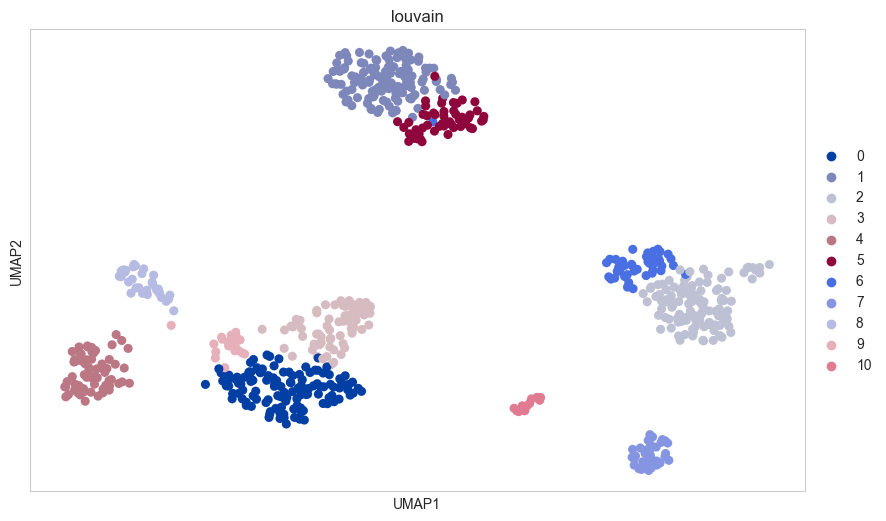

In [51]:
sc.pl.umap(adata, color='louvain')

### 1.1 Data Preprocessing

Single-cell RNA-seq data requires preprocessing before analysis:
- **Log transformation**: Gene expression counts are typically log-normalized
- **Feature selection**: Select highly variable genes
- **Normalization**: Scale data for downstream analysis


In [26]:
# Data preprocessing
print("Original data statistics:")
print(f"Mean expression: {data.values.mean():.2f}")
print(f"Std expression: {data.values.std():.2f}")
print(f"Min expression: {data.values.min():.2f}")
print(f"Max expression: {data.values.max():.2f}")

# Check if data is already log-transformed (mean < 10 suggests log-transformed)
# If not, apply log transformation
if data.values.mean() > 10:
    # Data appears to be raw counts, apply log transformation
    print("\nApplying log transformation (log1p)...")
    data_log = np.log1p(data.values)  # log(1+x) transformation
else:
    # Data appears to be already log-transformed
    print("\nData appears to be already log-transformed, skipping log transformation...")
    data_log = data.values.copy()

# Handle any negative or infinite values (replace with 0)
data_log = np.nan_to_num(data_log, nan=0.0, posinf=0.0, neginf=0.0)
# Ensure non-negative values
data_log = np.maximum(data_log, 0)

# Select highly variable genes (top 1000 most variable)
gene_variance = np.var(data_log, axis=0)
# Filter out genes with zero variance
non_zero_var_idx = np.where(gene_variance > 0)[0]
if len(non_zero_var_idx) < 1000:
    top_genes_idx = non_zero_var_idx[np.argsort(gene_variance[non_zero_var_idx])[::-1]]
    print(f"\nWarning: Only {len(non_zero_var_idx)} genes with non-zero variance found.")
else:
    top_genes_idx = non_zero_var_idx[np.argsort(gene_variance[non_zero_var_idx])[-1000:][::-1]]
data_selected = data_log[:, top_genes_idx]

print(f"\nAfter preprocessing:")
print(f"Selected {len(top_genes_idx)} highly variable genes")
print(f"Data shape: {data_selected.shape}")
print(f"Log data stats - Min: {data_log.min():.2f}, Max: {data_log.max():.2f}, Mean: {data_log.mean():.2f}")

# Store for later use
X = data_selected


Original data statistics:
Mean expression: -0.00
Std expression: 1.00
Min expression: -2.03
Max expression: 28.41

Data appears to be already log-transformed, skipping log transformation...


After preprocessing:
Selected 765 highly variable genes
Data shape: (700, 765)
Log data stats - Min: 0.00, Max: 28.41, Mean: 0.33


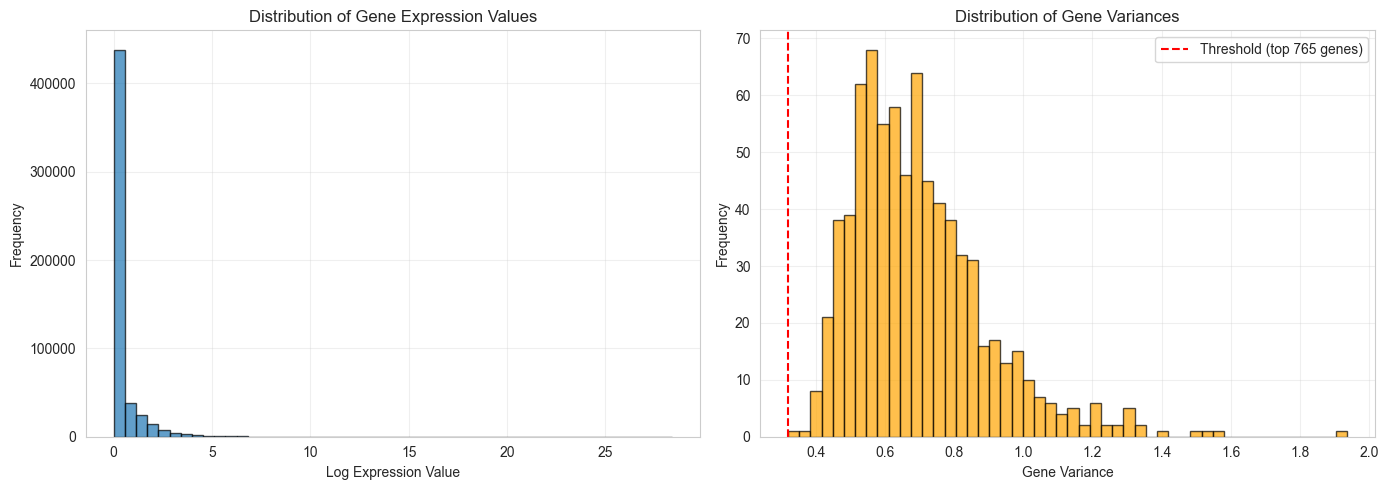

In [27]:
# Visualize data distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of gene expression values
# Filter out infinite and NaN values for visualization
data_log_flat = data_log.flatten()
data_log_flat = data_log_flat[np.isfinite(data_log_flat)]
axes[0].hist(data_log_flat, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Log Expression Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Gene Expression Values')
axes[0].grid(True, alpha=0.3)

# Variance of genes
axes[1].hist(gene_variance, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(gene_variance[top_genes_idx[-1]], color='red', linestyle='--', 
                label=f'Threshold (top {len(top_genes_idx)} genes)')
axes[1].set_xlabel('Gene Variance')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Gene Variances')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Data Visualization using UMAP and t-SNE

UMAP (Uniform Manifold Approximation and Projection) and t-SNE (t-distributed Stochastic Neighbor Embedding) are powerful techniques for visualizing high-dimensional data in 2D or 3D space.

### UMAP vs t-SNE:
- **t-SNE**: Better at preserving local structure, but slower and can't handle new data points
- **UMAP**: Faster, preserves both local and global structure, can transform new data


In [28]:
# Install umap-learn if not already installed
# !pip install umap-learn

try:
    import umap
    print("UMAP library imported successfully!")
except ImportError:
    print("UMAP not installed. Please install with: pip install umap-learn")
    print("Continuing with t-SNE only...")


UMAP library imported successfully!


In [29]:
# Standardize the data for better visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Scaled data mean: {X_scaled.mean():.4f}, std: {X_scaled.std():.4f}")


Scaled data shape: (700, 765)
Scaled data mean: -0.0000, std: 1.0000


Running UMAP...
UMAP embedding shape: (700, 2)


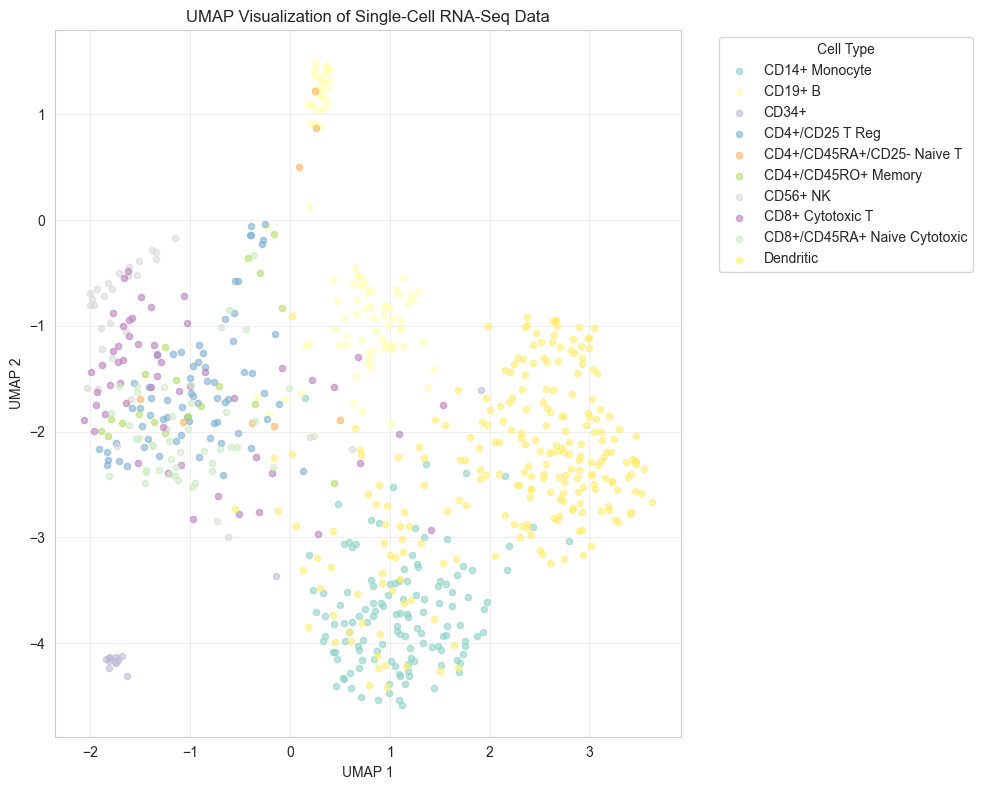

In [30]:
# UMAP visualization
try:
    import umap
    
    print("Running UMAP...")
    reducer_umap = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = reducer_umap.fit_transform(X_scaled)
    
    print(f"UMAP embedding shape: {X_umap.shape}")
    
    # Plot UMAP
    plt.figure(figsize=(10, 8))
    if true_cell_types is not None:
        unique_types = np.unique(true_cell_types)
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
        for i, cell_type in enumerate(unique_types):
            mask = true_cell_types == cell_type
            plt.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                       c=[colors[i]], label=cell_type, alpha=0.6, s=20)
        plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, s=20, c='steelblue')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP Visualization of Single-Cell RNA-Seq Data')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("UMAP not available, skipping...")


Running t-SNE (this may take a few minutes)...
t-SNE embedding shape: (700, 2)


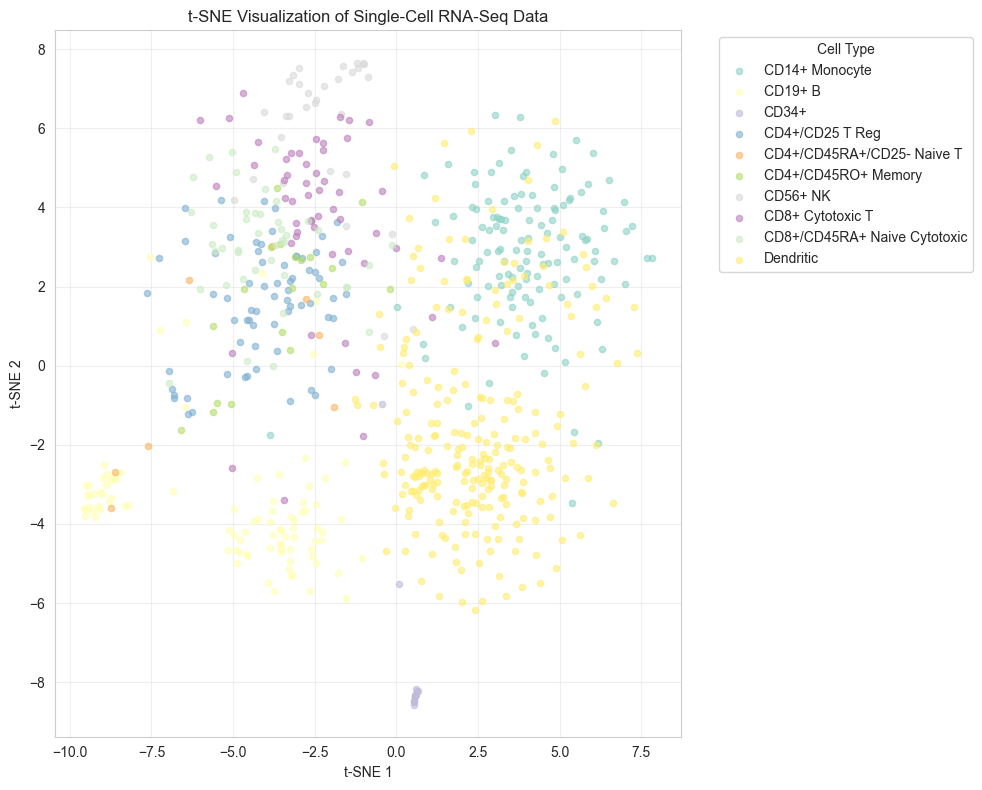

In [31]:
# t-SNE visualization
print("Running t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

print(f"t-SNE embedding shape: {X_tsne.shape}")

# Plot t-SNE
plt.figure(figsize=(10, 8))
if true_cell_types is not None:
    unique_types = np.unique(true_cell_types)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    for i, cell_type in enumerate(unique_types):
        mask = true_cell_types == cell_type
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   c=[colors[i]], label=cell_type, alpha=0.6, s=20)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, s=20, c='steelblue')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of Single-Cell RNA-Seq Data')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Dimension Reduction using PCA

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that finds the directions of maximum variance in the data.

### Why PCA?
- **Dimensionality reduction**: Reduce from thousands of genes to a few principal components
- **Noise reduction**: First components capture signal, later components capture noise
- **Visualization**: Can visualize data in 2D/3D using first 2-3 PCs
- **Preprocessing**: Often used before clustering or other analyses


In [32]:
# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=50)  # Keep top 50 components
X_pca = pca.fit_transform(X_scaled)

print(f"PCA transformed data shape: {X_pca.shape}")
print(f"Original data shape: {X_scaled.shape}")
print(f"\nVariance explained by first 10 components:")
for i in range(min(10, len(pca.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({pca.explained_variance_ratio_[i]*100:.2f}%)")


Applying PCA...
PCA transformed data shape: (700, 50)
Original data shape: (700, 765)

Variance explained by first 10 components:
  PC1: 0.0410 (4.10%)
  PC2: 0.0324 (3.24%)
  PC3: 0.0238 (2.38%)
  PC4: 0.0189 (1.89%)
  PC5: 0.0150 (1.50%)
  PC6: 0.0136 (1.36%)
  PC7: 0.0113 (1.13%)
  PC8: 0.0071 (0.71%)
  PC9: 0.0059 (0.59%)
  PC10: 0.0058 (0.58%)


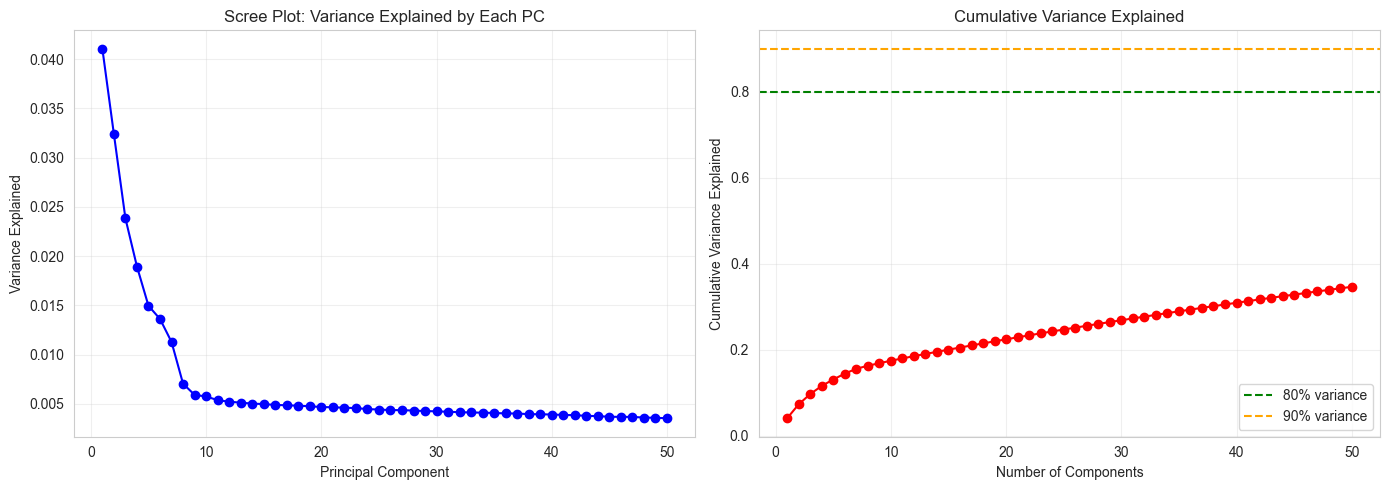


Number of components needed for 80% variance: 1
Number of components needed for 90% variance: 1


In [33]:
# Visualize variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
n_components_to_plot = min(50, len(pca.explained_variance_ratio_))
axes[0].plot(range(1, n_components_to_plot + 1), 
             pca.explained_variance_ratio_[:n_components_to_plot], 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Scree Plot: Variance Explained by Each PC')
axes[0].grid(True, alpha=0.3)

# Cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, n_components_to_plot + 1), 
             cumulative_variance[:n_components_to_plot], 'ro-')
axes[1].axhline(y=0.8, color='g', linestyle='--', label='80% variance')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 80% and 90% variance
n_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"\nNumber of components needed for 80% variance: {n_80}")
print(f"Number of components needed for 90% variance: {n_90}")


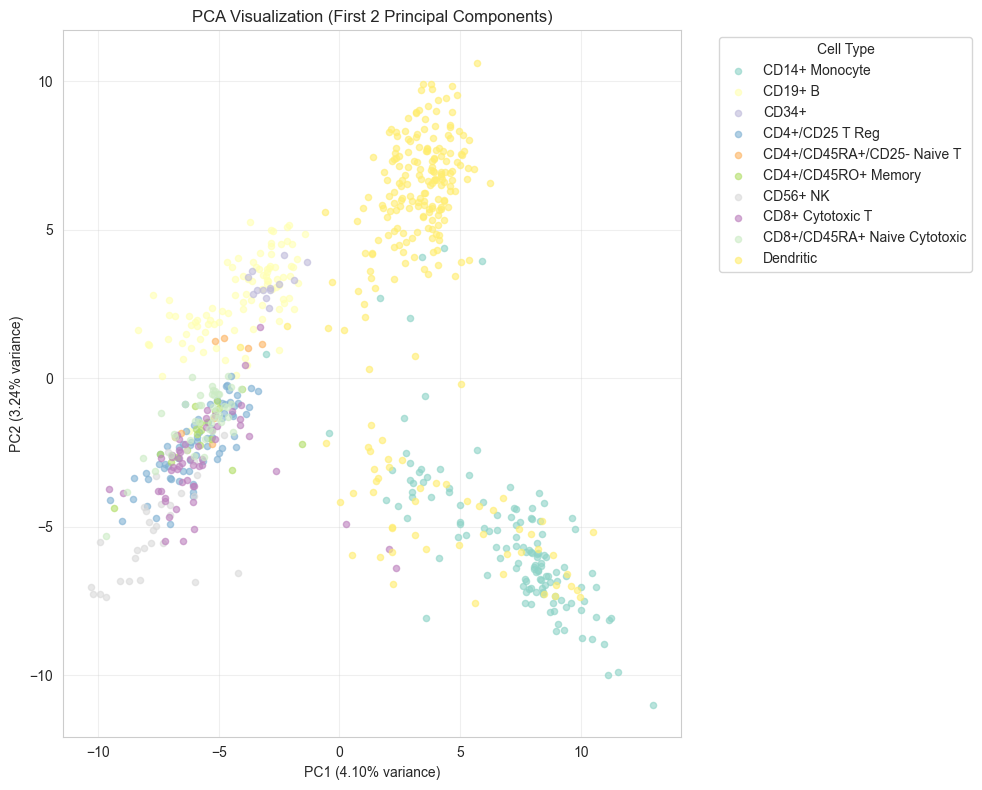

In [34]:
# Visualize PCA in 2D
plt.figure(figsize=(10, 8))
if true_cell_types is not None:
    unique_types = np.unique(true_cell_types)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    for i, cell_type in enumerate(unique_types):
        mask = true_cell_types == cell_type
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[colors[i]], label=cell_type, alpha=0.6, s=20)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=20, c='steelblue')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('PCA Visualization (First 2 Principal Components)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 4. K-Means Clustering to Identify Cell Clusters

K-means clustering is a popular unsupervised learning algorithm that partitions data into k clusters by minimizing within-cluster variance.

### Steps:
1. Choose number of clusters (k)
2. Initialize k centroids randomly
3. Assign each cell to nearest centroid
4. Update centroids to mean of assigned cells
5. Repeat until convergence


In [35]:
# Determine optimal number of clusters using elbow method and silhouette score
from sklearn.metrics import silhouette_score

# Use PCA-reduced data for faster computation
X_for_clustering = X_pca[:, :30]  # Use first 30 PCs

k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_for_clustering, labels)
    silhouette_scores.append(sil_score)
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")


Testing different numbers of clusters...
  k=2: Inertia=124924.97, Silhouette=0.1623
  k=3: Inertia=109862.98, Silhouette=0.1573
  k=4: Inertia=99118.11, Silhouette=0.1965
  k=5: Inertia=90710.45, Silhouette=0.2225
  k=6: Inertia=83969.27, Silhouette=0.2423
  k=7: Inertia=77513.70, Silhouette=0.2595
  k=8: Inertia=73696.28, Silhouette=0.2598
  k=9: Inertia=71715.73, Silhouette=0.2440
  k=10: Inertia=69947.88, Silhouette=0.1894


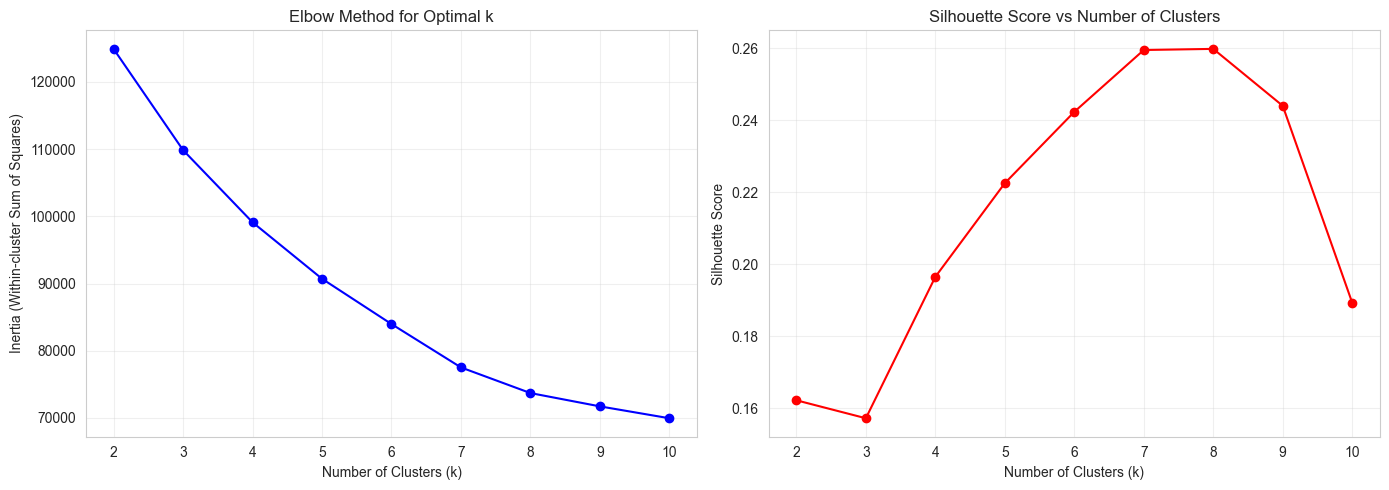


Optimal number of clusters (based on silhouette score): 8


In [36]:
# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (based on silhouette score): {optimal_k}")


In [37]:
# Apply K-means with optimal k
k = optimal_k if 'optimal_k' in locals() else 4
print(f"Applying K-means clustering with k={k}...")

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)

print(f"Clustering complete!")
print(f"Cluster sizes: {np.bincount(cluster_labels)}")

# Calculate silhouette score
sil_score = silhouette_score(X_for_clustering, cluster_labels)
print(f"Silhouette score: {sil_score:.4f}")

# If we have true labels, calculate adjusted rand index
if true_cell_types is not None:
    ari = adjusted_rand_score(true_cell_types, cluster_labels)
    print(f"Adjusted Rand Index (vs true labels): {ari:.4f}")


Applying K-means clustering with k=8...
Clustering complete!
Cluster sizes: [ 13 191  66 170  31 144  23  62]
Silhouette score: 0.2598
Adjusted Rand Index (vs true labels): 0.5742


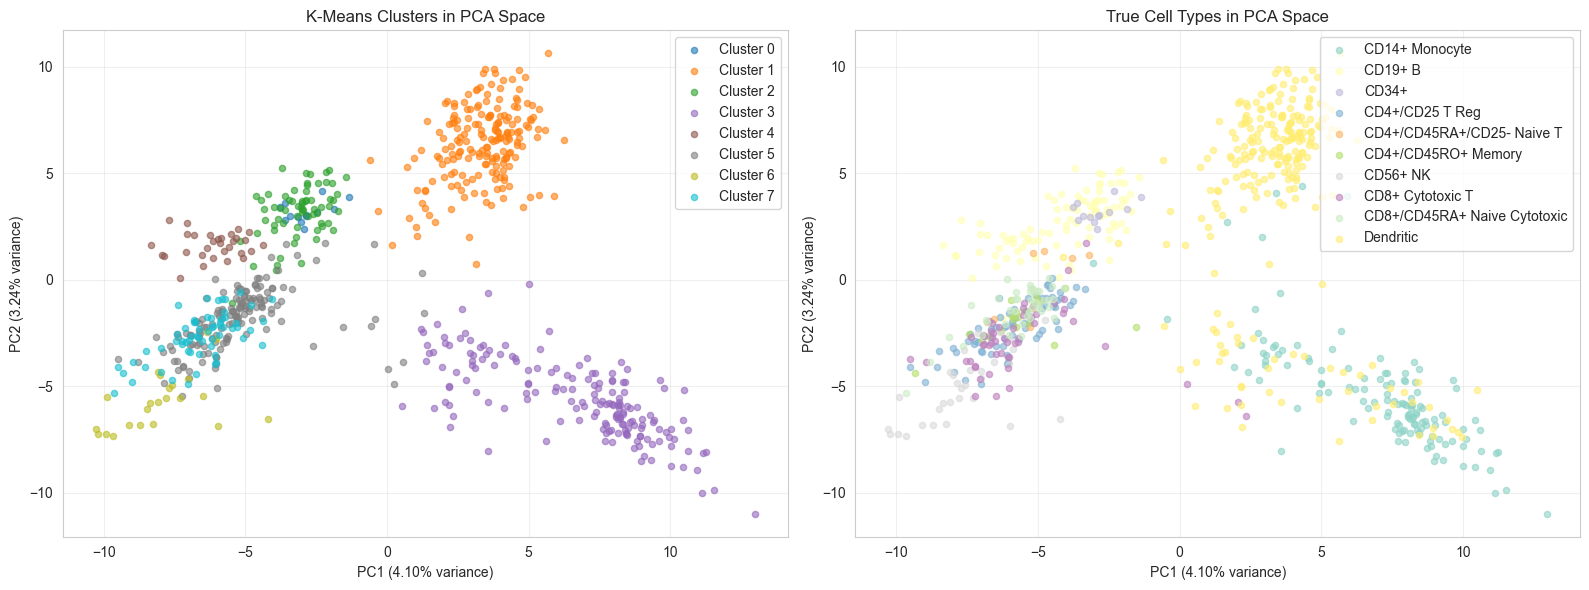

In [38]:
# Visualize clusters in PCA space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA with cluster labels
unique_clusters = np.unique(cluster_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[colors[i]], label=f'Cluster {cluster}', alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
axes[0].set_title('K-Means Clusters in PCA Space')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# If available, compare with true labels
if true_cell_types is not None:
    unique_types = np.unique(true_cell_types)
    type_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    for i, cell_type in enumerate(unique_types):
        mask = true_cell_types == cell_type
        axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=[type_colors[i]], label=cell_type, alpha=0.6, s=20)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
    axes[1].set_title('True Cell Types in PCA Space')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].axis('off')

plt.tight_layout()
plt.show()


### 4.1 Associate Cell Clusters to Cell Types

After clustering, we can identify which cell types each cluster represents by:
- Finding marker genes (highly expressed genes) for each cluster
- Comparing with known cell type markers
- Using domain knowledge


In [39]:
# Find marker genes for each cluster
# Marker genes are genes that are highly expressed in one cluster compared to others

from scipy import stats

n_markers = 10  # Number of top marker genes per cluster
marker_genes = {}

for cluster_id in unique_clusters:
    # Get cells in this cluster
    cluster_mask = cluster_labels == cluster_id
    
    # Calculate mean expression in cluster vs others
    cluster_mean = X[cluster_mask].mean(axis=0)
    other_mean = X[~cluster_mask].mean(axis=0)
    
    # Calculate fold change
    fold_change = cluster_mean - other_mean
    
    # Get top marker genes
    top_marker_idx = np.argsort(fold_change)[-n_markers:][::-1]
    marker_genes[cluster_id] = {
        'genes': top_marker_idx,
        'fold_change': fold_change[top_marker_idx]
    }
    
    print(f"\nCluster {cluster_id} top {n_markers} marker genes:")
    for idx, fc in zip(top_marker_idx[:5], fold_change[top_marker_idx][:5]):
        print(f"  Gene {idx}: fold change = {fc:.4f}")



Cluster 0 top 10 marker genes:
  Gene 1: fold change = 7.1001
  Gene 0: fold change = 5.7934
  Gene 32: fold change = 5.1034
  Gene 18: fold change = 4.9518
  Gene 158: fold change = 4.9119

Cluster 1 top 10 marker genes:
  Gene 574: fold change = 1.4985
  Gene 619: fold change = 1.3552
  Gene 727: fold change = 1.3132
  Gene 706: fold change = 1.3034
  Gene 707: fold change = 1.3022

Cluster 2 top 10 marker genes:
  Gene 28: fold change = 2.4993
  Gene 104: fold change = 2.4741
  Gene 20: fold change = 2.4375
  Gene 308: fold change = 2.3824
  Gene 116: fold change = 2.1723

Cluster 3 top 10 marker genes:
  Gene 561: fold change = 1.5749
  Gene 506: fold change = 1.5425
  Gene 142: fold change = 1.4918
  Gene 623: fold change = 1.4835
  Gene 477: fold change = 1.4117

Cluster 4 top 10 marker genes:
  Gene 51: fold change = 4.1362
  Gene 44: fold change = 3.9098
  Gene 71: fold change = 3.7716
  Gene 401: fold change = 3.5323
  Gene 48: fold change = 3.3811

Cluster 5 top 10 marker ge

## 5. Advanced Approaches

### 5a. Variational Autoencoder (VAE) for Better Dimension Reduction

VAEs are deep learning models that learn a low-dimensional latent representation of the data. They are particularly powerful for single-cell data because:

- **Non-linear**: Can capture complex, non-linear relationships
- **Probabilistic**: Provides uncertainty estimates
- **Denoising**: Can help remove technical noise
- **Batch correction**: Can integrate data from different batches/experiments


In [40]:
# VAE implementation using PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [41]:
# Define VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=32):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Latent space (mean and log variance)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [42]:
# Prepare data for VAE
input_dim = X_scaled.shape[1]
latent_dim = 32  # Dimension of latent space

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled).to(device)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize model
vae = VAE(input_dim=input_dim, hidden_dim=128, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

print(f"VAE Model:")
print(f"  Input dimension: {input_dim}")
print(f"  Latent dimension: {latent_dim}")
print(f"  Number of parameters: {sum(p.numel() for p in vae.parameters())}")


VAE Model:
  Input dimension: 765
  Latent dimension: 32
  Number of parameters: 242237


In [43]:
# Training function
def train_vae(model, dataloader, optimizer, epochs=50):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data,) in enumerate(dataloader):
            optimizer.zero_grad()
            
            # Forward pass
            recon, mu, logvar = model(data)
            
            # Reconstruction loss (MSE)
            recon_loss = nn.functional.mse_loss(recon, data, reduction='sum')
            
            # KL divergence loss
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            # Total loss
            loss = recon_loss + 0.1 * kl_loss  # Weight KL loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    return losses

# Train VAE
print("Training VAE...")
vae_losses = train_vae(vae, dataloader, optimizer, epochs=50)


Training VAE...
Epoch [10/50], Loss: 716.6619
Epoch [20/50], Loss: 654.7238
Epoch [30/50], Loss: 628.4805
Epoch [40/50], Loss: 597.1970
Epoch [50/50], Loss: 567.6585


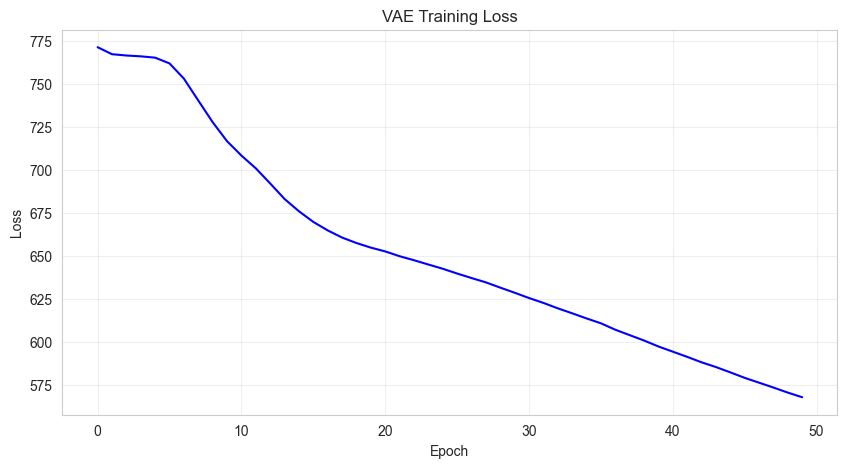

In [44]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(vae_losses, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.grid(True, alpha=0.3)
plt.show()


In [45]:
# Extract latent representation
vae.eval()
with torch.no_grad():
    mu, _ = vae.encode(X_tensor)
    X_vae = mu.cpu().numpy()

print(f"VAE latent representation shape: {X_vae.shape}")
print(f"Original data shape: {X_scaled.shape}")
print(f"Dimensionality reduction: {X_scaled.shape[1]} -> {X_vae.shape[1]}")


VAE latent representation shape: (700, 32)
Original data shape: (700, 765)
Dimensionality reduction: 765 -> 32


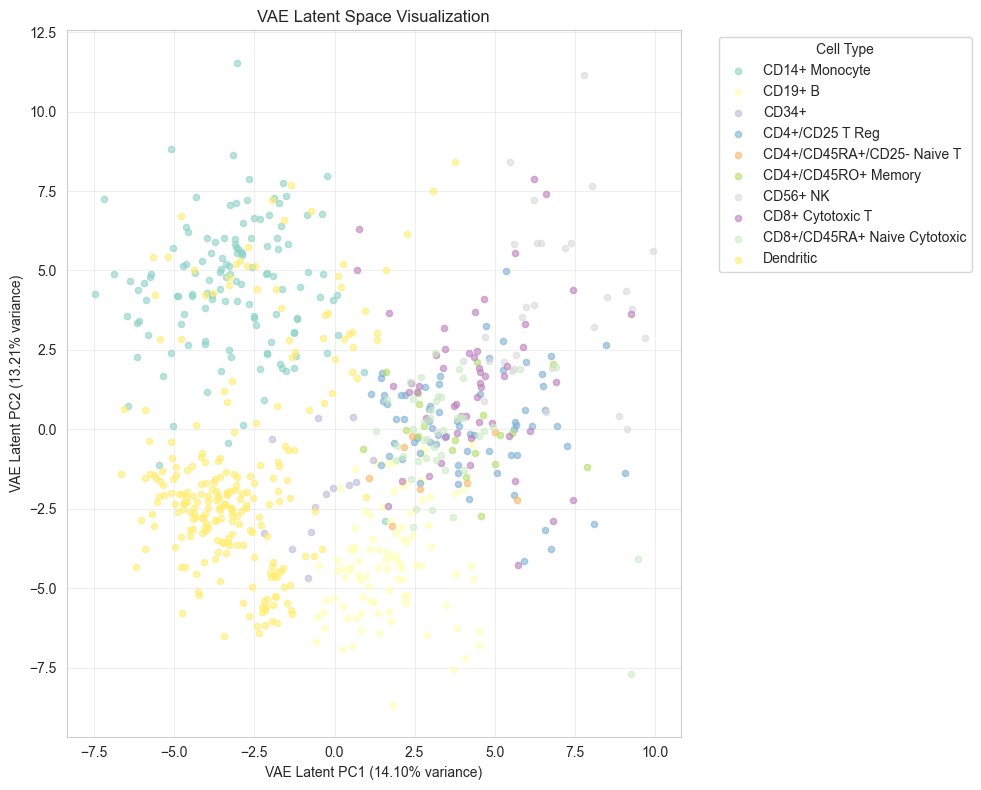

In [46]:
# Visualize VAE latent space using PCA
from sklearn.decomposition import PCA as skPCA

# Project VAE latent space to 2D for visualization
vae_pca = skPCA(n_components=2)
X_vae_2d = vae_pca.fit_transform(X_vae)

plt.figure(figsize=(10, 8))
if true_cell_types is not None:
    unique_types = np.unique(true_cell_types)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    for i, cell_type in enumerate(unique_types):
        mask = true_cell_types == cell_type
        plt.scatter(X_vae_2d[mask, 0], X_vae_2d[mask, 1], 
                   c=[colors[i]], label=cell_type, alpha=0.6, s=20)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.scatter(X_vae_2d[:, 0], X_vae_2d[:, 1], alpha=0.6, s=20, c='steelblue')
plt.xlabel(f'VAE Latent PC1 ({vae_pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'VAE Latent PC2 ({vae_pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('VAE Latent Space Visualization')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 5b. Louvain Graph-Based Clustering Method

Louvain clustering is a community detection algorithm that works on graphs. For single-cell data:

1. **Build a k-nearest neighbor (KNN) graph** from cells
2. **Apply Louvain algorithm** to find communities (clusters)

### Advantages over K-means:
- **No need to specify k**: Automatically determines number of clusters
- **Handles non-convex clusters**: Can find clusters of any shape
- **Works well with graph structure**: Leverages cell-cell similarity
- **Resolution parameter**: Can control cluster granularity


In [47]:
# Build KNN graph for Louvain clustering
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Use PCA-reduced data for faster computation
X_for_graph = X_pca[:, :30]

# Build KNN graph
k = 15  # Number of neighbors
print(f"Building KNN graph with k={k}...")

knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
knn.fit(X_for_graph)
distances, indices = knn.kneighbors(X_for_graph)

# Create adjacency matrix (symmetric)
n_cells = X_for_graph.shape[0]
adjacency = np.zeros((n_cells, n_cells))

for i in range(n_cells):
    for j in range(1, k):  # Skip self (first neighbor)
        neighbor = indices[i, j]
        adjacency[i, neighbor] = 1
        adjacency[neighbor, i] = 1  # Make symmetric

adjacency_sparse = csr_matrix(adjacency)
print(f"KNN graph built: {adjacency_sparse.nnz} edges")


Building KNN graph with k=15...
KNN graph built: 15568 edges


In [48]:
# Apply Louvain clustering

try:

    import igraph as ig

    import leidenalg

    

    # Convert to igraph format

    print("Converting to igraph format...")

    sources, targets = adjacency_sparse.nonzero()

    edges = list(zip(sources, targets))

    

    # Create igraph graph

    graph = ig.Graph(edges, directed=False)

    graph.simplify()  # Remove self-loops and multiple edges

    

    print(f"Graph: {graph.vcount()} vertices, {graph.ecount()} edges")

    

    # Apply Leiden algorithm (improved version of Louvain)

    print("Applying Leiden clustering (improved Louvain)...")

    partition = leidenalg.find_partition(graph, leidenalg.RBERVertexPartition, 
                                        resolution_parameter=0.5, seed=42)

    

    louvain_labels = np.array(partition.membership)

    

    print(f"Leiden clustering complete!")

    print(f"Number of clusters: {len(np.unique(louvain_labels))}")

    print(f"Cluster sizes: {np.bincount(louvain_labels)}")

    

    # Calculate modularity

    modularity = partition.modularity

    print(f"Modularity: {modularity:.4f}")

    

except ImportError:

    print("igraph or leidenalg not installed. Using alternative: Agglomerative clustering on KNN graph...")

    

    from sklearn.cluster import AgglomerativeClustering

    

    # Apply hierarchical clustering

    n_clusters = 4  # Can be determined automatically

    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

    louvain_labels = agg_clustering.fit_predict(X_for_graph)

    

    print(f"Agglomerative clustering complete!")

    print(f"Number of clusters: {len(np.unique(louvain_labels))}")

    print(f"Cluster sizes: {np.bincount(louvain_labels)}")



Converting to igraph format...
Graph: 700 vertices, 7784 edges
Applying Leiden clustering (improved Louvain)...


TypeError: __init__() got an unexpected keyword argument 'resolution_parameter'

In [ ]:
# Visualize Louvain clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# In PCA space
unique_louvain = np.unique(louvain_labels)
louvain_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_louvain)))

for i, cluster in enumerate(unique_louvain):
    mask = louvain_labels == cluster
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  c=[louvain_colors[i]], label=f'Cluster {cluster}', alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
axes[0].set_title('Louvain/Leiden Clusters in PCA Space')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

# In UMAP space (if available)
if 'X_umap' in locals():
    for i, cluster in enumerate(unique_louvain):
        mask = louvain_labels == cluster
        axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c=[louvain_colors[i]], label=f'Cluster {cluster}', alpha=0.6, s=20)
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].set_title('Louvain/Leiden Clusters in UMAP Space')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].axis('off')

plt.tight_layout()
plt.show()


## Summary and Conclusions

In this tutorial, we explored various unsupervised learning techniques for single-cell RNA-seq data:

### Key Takeaways:

1. **Data Visualization**:
   - UMAP and t-SNE provide powerful 2D visualizations of high-dimensional data
   - UMAP is generally faster and preserves both local and global structure

2. **Dimensionality Reduction**:
   - PCA is a linear method that's fast and interpretable
   - VAE provides non-linear dimensionality reduction and can denoise data

3. **Clustering**:
   - K-means is simple and fast but requires specifying k and assumes spherical clusters
   - Louvain/Leiden clustering works on graphs and can find clusters of any shape

4. **Best Practices**:
   - Always preprocess data (log transform, select variable genes, normalize)
   - Use multiple methods and compare results
   - Validate clusters using marker genes and biological knowledge

### Further Reading:
- Scanpy: Python library for single-cell analysis
- Seurat: R package for single-cell genomics
- scVI: Deep generative models for single-cell data
